## Introduction to network-based analysis in biomedicine with Python (Part 2)

<b>Network data mining</b> is the process of discovering patterns, relationships and insights in networks or graphs. This section is dedicated to the study of network data mining algorithms which are often used to provide novel insights into pathogenesis and etiology, as well as in the identification of new targets and applications for drugs. 

Network data mining algorithms can be divided into 4 main categories:

1. Traversal algorithms 
2. Algorithms to compute centrality scores 
3. Path-finding algorithms 
4. Algorithms for community detection 

In part 1 of this tutorial, we discussed the three most commonly used algorithms to compute the centrality scores in a network — degree, betweenness and closeness. Here, we take a deeper look into the other three types of network data mining algorithms. We will see how to use these algorithms to extract relevant information from a PPI network including information on SARS-CoV-2 targets and known drug-target associations.


#### Topic overview:

##### 0. Data preparation and network construction

##### 1. Traversal algorithms: BFS and DFS

##### 2. Path-finding algorithm: Shortest path (Dijkstra)

##### 3. Sub-graph finding algorithm: Steiner tree

##### 4. Network proximity finding algorithm: Random Walk with Restart

##### 5. Community detection algorithm: Girvan-Newman method

#### Data preparation and network construction

In [1]:
# Upload Python modules
import pandas as pd
import networkx as nx
import matplotlib.pylab as plt
from networkx.algorithms.approximation import steiner_tree
from networkx.algorithms.community.centrality import girvan_newman

In [2]:
# Reading the edge list from STRING
edge_list = pd.read_table("Data/STRING_network.tsv")

# Creating network from edge list 
STRING_PPI = nx.from_pandas_edgelist(df = edge_list,
                            source = "node1", 
                            target = "node2",
                            edge_attr = "combined_score")
STRING_PPI_pos = nx.spring_layout(STRING_PPI, seed = 20)

#### Graph search or traversal algorithms
Graph search or graph traversal algorithms are used for exploring the graphs or networks either for general discovery or explicit search. They form the groundwork for moving through graphs. The algorithms carve paths within the network irrespective of the fact if the paths are optimal. The two fundamental graph traversal algorithms are breadth-first search (BFS) and depth-first search (DFS).

The BFS algorithm starts from a selected node of a graph and explores all its neighbours at one hop away before visiting all the neighbours at two hops away, and so on. On the other hand, the DFS algorithm starts from a chosen node, picks one of its neighbours, and then traverses as far as it can along that path before backtracking. 

These two algorithms form the basis of several other network data mining algorithms.

<img src = "Figures/Breadth_first_search.gif" alt = "BFS" width = "400" height = "400">

<strong>Figure:</strong> The path taken by BFS.


<img src = "Figures/Depth_first_search.gif" alt = "DFS" width = "400" height = "400">

<strong>Figure:</strong> The path taken by DFS.

Image from https://commons.wikimedia.org/


In NetworkX, the functions <code>bfs_tree</code> and <code>dfs_tree</code> are used to obtain the tree starting from a <code>source</code> node. Let us see how the BFS and DFS trees differ in our example network if JAK1 is considered as the starting node.

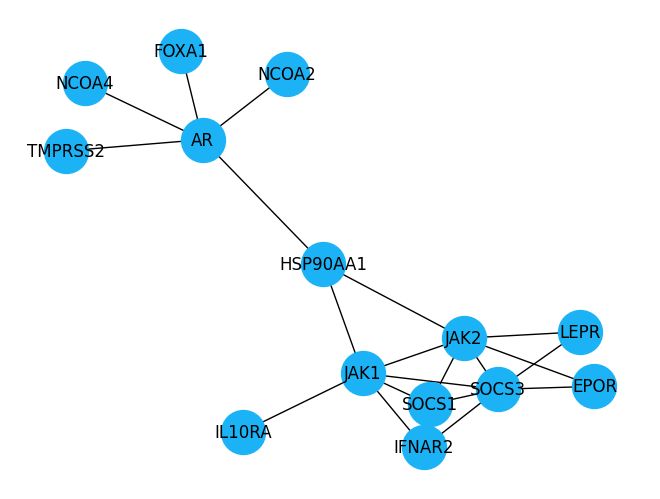

In [3]:
# The original STRING PPI network
nx.draw(STRING_PPI, with_labels = True, pos = STRING_PPI_pos, node_size = 1000, node_color = "#1BB3F5")

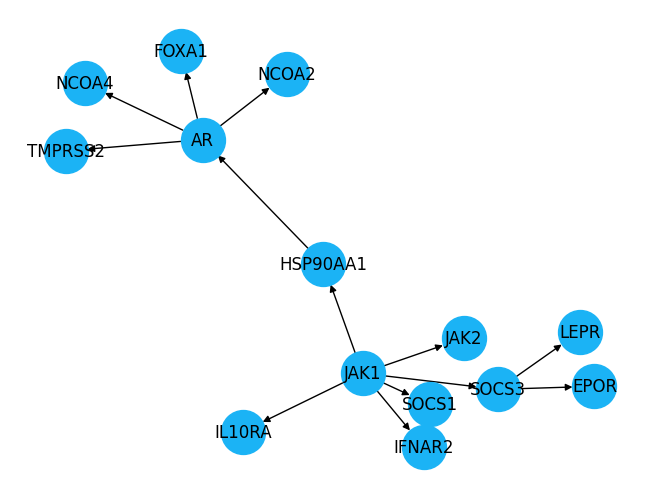

In [4]:
# BFS starting from JAK1
bfs_net = nx.bfs_tree(STRING_PPI, source = "JAK1")
nx.draw(bfs_net, with_labels = True, pos = STRING_PPI_pos, node_size = 1000, node_color = "#1BB3F5")

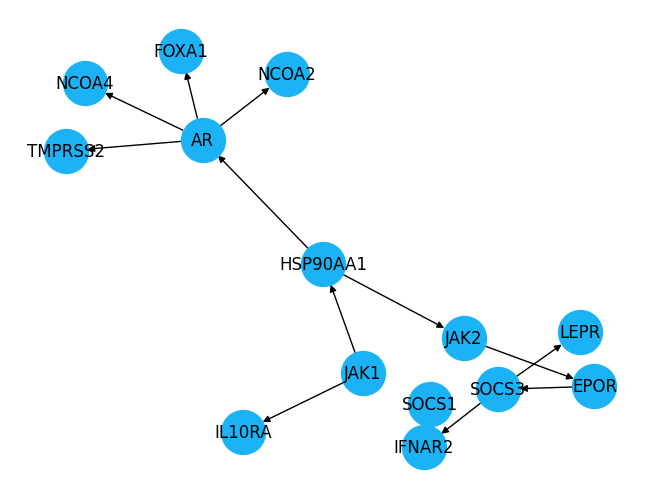

In [5]:
# DFS tree starting from JAK1
dfs_net = nx.dfs_tree(STRING_PPI, source = "JAK1")
nx.draw(dfs_net, with_labels = True, pos = STRING_PPI_pos, node_size = 1000, node_color = "#1BB3F5")

We can clearly see the difference between the two algorithms. In BFS, all the six immediate neighbours of JAK1 are explored first and only then the node at two hops. Contrastingly, even thogh SOCS1 is a direct neighbour of JAK1, it is only explored after EPOR since the algorithm chooses to explore the network through HSP90AA1 first.

#### Path finding algorithms
Unlike the graph search algorithms discussed above, the path finding algorithms are more focussed on identifying optimal paths between a pair of nodes in the network. However, the graph search algorithms forms the foundation of the path finding algorithms.

##### Shortest Path (Dijkstra)
The shortest path algorithms calculates the shortest paths between a pair of nodes. In other words, it identifies the path between two nodes with the minimum number of hops or the least weight in case of a weighted network.

For example, let us try and find the shortest path between the proteins LEPR and FOXA1 in the example network. The simpliest way is to first identify all the possible paths between the two proteins and then identify the path with the smallest hops. In NetworkX, the function <code>all_simple_paths</code> can be used to retrieve all the possible paths betwen the <code>source</code> and the <code>target</code> nodes. The following table shows all the possible paths and the number of hops required. 

In [6]:
# Print all possible paths and their lengths
paths_df = pd.DataFrame({"Path": pd.Series(dtype = "str"), "Hops": pd.Series(dtype = "int")})
all_paths = nx.all_simple_paths(STRING_PPI, source = "LEPR", target = "FOXA1")
for i, path in enumerate(all_paths):
    paths_df.loc[i] = [path, len(path) - 1]
    
paths_df = paths_df.sort_values(by = "Hops")
paths_df

,Path,Hops
5,"[LEPR, JAK2, HSP90AA1, AR, FOXA1]",4
28,"[LEPR, SOCS3, JAK1, HSP90AA1, AR, FOXA1]",5
32,"[LEPR, SOCS3, JAK2, HSP90AA1, AR, FOXA1]",5
6,"[LEPR, JAK2, JAK1, HSP90AA1, AR, FOXA1]",5
25,"[LEPR, SOCS3, IFNAR2, JAK1, HSP90AA1, AR, FOXA1]",6
31,"[LEPR, SOCS3, JAK1, JAK2, HSP90AA1, AR, FOXA1]",6
40,"[LEPR, SOCS3, SOCS1, JAK2, HSP90AA1, AR, FOXA1]",6
17,"[LEPR, SOCS3, EPOR, JAK2, HSP90AA1, AR, FOXA1]",6
33,"[LEPR, SOCS3, JAK2, JAK1, HSP90AA1, AR, FOXA1]",6
14,"[LEPR, JAK2, SOCS3, JAK1, HSP90AA1, AR, FOXA1]",6


While the above method looks easy in case of a small unweighted network, it may become computationally expensive with a larger, complex and weighted network. While dealing with such networks, it thus becomes imperative to use more efficient algorithms like that of Dijkstra's for identifying the shortest paths between two nodes in a network.

Dijkstra's algorithm scans the network iteratively to find a path with the lowest weight from the source node to the other nodes in the network until it has visited all the nodes. At the end, there exist's at least one path from the source node to all other nodes in the network with lowest cumulative edge weight which can be used to identify the shortest path from the source to the target node. The algorithm is tailored to work with networks having positive edge weights, however, in several  implementations of the algorithm, an edge weight of 1 is assigned to unweighted networks.

<img src = "Figures/Dijkstras_algo.png" alt = "Dijkstra's algorithm" width = "700" height = "400">

<strong>Figure:</strong> Steps of execution of Dijkstra's algorithm.

Image from <a href = "https://steemit.com/popularscience/@krishtopa/dijkstra-s-algorithm-of-finding-optimal-paths" target = "_blank">Dijkstra’s algorithm of finding optimal paths</a>


In NetworkX, the function <code>shortest_path</code> uses the Dijkstra's algorithm by default to calculate the shortest path between the <code>source</code> and <code>target</code> nodes. 

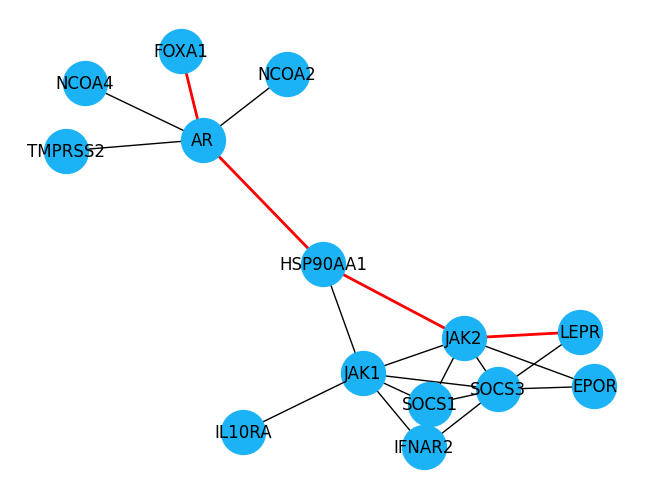

In [7]:
# Highlight the shortest path in the network
nx.draw(STRING_PPI, with_labels = True, pos = STRING_PPI_pos, node_size = 1000, node_color = "#1BB3F5")
shortest_path = nx.shortest_path(STRING_PPI, source = "LEPR", target = "FOXA1", method = "dijkstra")
path_edges = list(zip(shortest_path,shortest_path[1:]))
# edge_weights = nx.get_edge_attributes(STRING_PPI, "combined_score")
# nx.draw_networkx_edge_labels(STRING_PPI, pos = STRING_PPI_pos, edge_labels = edge_weights)
nx.draw_networkx_edges(STRING_PPI, STRING_PPI_pos, edgelist = path_edges, edge_color = "red", width = 2)
plt.show()

#### Sub-graph finding algorithm

##### Steiner tree (Approximation)
Steiner tree algorithms solve a classical combinatorial optimization problem which focuses on identifying a subgraph of minimum cost connecting a given set of seed nodes. The input biological network must include edges with costs which correspond to confidence or frequency of that interaction, and prizes for the nodes, which could be linked to the measurements of differential expression. 

/home/users/aghosh/.local/lib/python3.9/site-packages/networkx/utils/decorators.py:770: FutureWarning: steiner_tree will change default method from 'kou' to 'mehlhorn' in version 3.2.
Set the `method` kwarg to remove this warning.
  return argmap._lazy_compile(__wrapper)(*args, **kwargs)


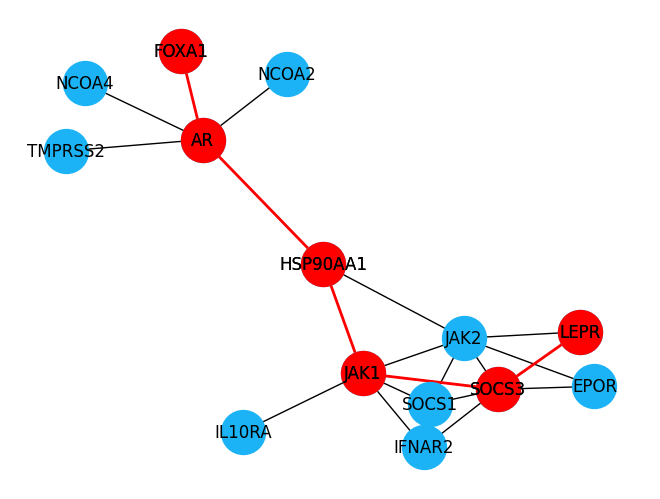

In [8]:
steiner_tree_net = steiner_tree(STRING_PPI, terminal_nodes = ["LEPR", "FOXA1", "JAK1"])
nx.draw(STRING_PPI, with_labels = True, pos = STRING_PPI_pos, node_size = 1000, node_color = "#1BB3F5")
nx.draw(steiner_tree_net, with_labels = True, pos = STRING_PPI_pos, node_size = 1000, node_color = "red", edge_color = "red", width = 2)

#### Network proximity finding algorithm

##### Random Walk with Restart (RWR)
The Random Walk algorithm is used to identify the nodes that are more frequently visited on a random path in a graph. It simulates a traversal of the graph in which the crossed graph edges are chosen at random. After repeating this process several times, it should then be possible to measure the node-to-node proximities. In a classic RW, each edge has the same, possibly weighted, probability of being selected, and this probability is not influenced by the previously visited nodes. 

The most used variant of RWs is called Random Walk with Restart. It contains an additional component called restart probability that decides the probability of the walker to return to the origin node after each step taken.

RWR has been used to explore the network vicinity of gene/protein seeds to study their functions by virtue of guilt-by-association i.e., genes that are closely associated tend to have similar functions. Similarly, RWR has also been used to prioritize candidate disease genes by estimating the proximities of the genes in the network from known disease genes.

<p style="padding: 10px 10px 10px 10px; border: 2px solid blue;">
<b>Box 2.1: Guilt by association (GBA)</b><br>
The biological principle of guilt by association states that genes with related functions tend to share similar properties such as genetic or physical interactions. Conversely, interacting genes may have similar functions. This principle has been extensively used in network biology to infer the function of genes with previously unreported functions.
</p>

In [9]:
rwr = nx.pagerank(STRING_PPI, personalization = {"JAK1": 1})
rwr_df = pd.DataFrame.from_dict(rwr, orient = "index").reset_index()
rwr_df.columns = ["Protein", "Visiting probability"]
rwr_df.sort_values(by = ["Visiting probability"], ascending = False, inplace = True)
rwr_df.reset_index(drop = True, inplace = True)
rwr_df

,Protein,Visiting probability
0,JAK1,0.286563
1,SOCS3,0.136763
2,JAK2,0.133160
3,SOCS1,0.101967
4,IFNAR2,0.081639
5,HSP90AA1,0.067123
6,AR,0.045064
7,IL10RA,0.040596
8,EPOR,0.038239
9,LEPR,0.038239


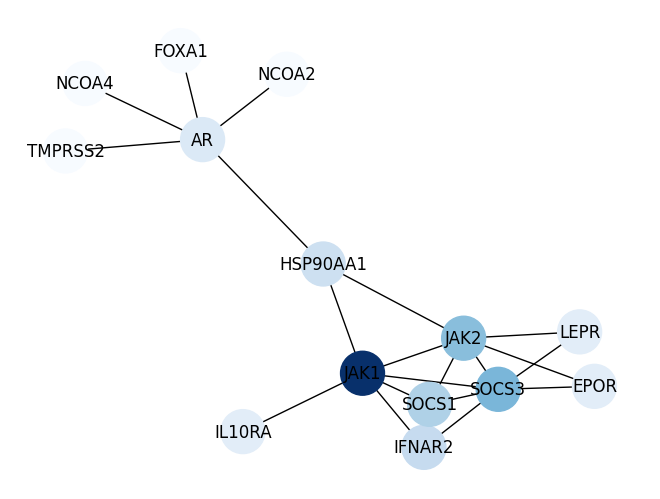

In [10]:
# Plot the RWR probability values on the network
rwr = {key : round(rwr[key], 2) for key in rwr}
nx.draw(STRING_PPI, with_labels = True, pos = STRING_PPI_pos, node_size = 1000, node_color = list(rwr.values()), cmap=plt.cm.Blues)

#### Community detection algorithms
In network biology or graph theory in general, a community is defined as a subset of nodes within the graph such that connections between the nodes are denser than connections with the rest of the network. Community detection algorithms are used to find such densely connected groups of nodes in a network. Community detection is an integral part of biological network analysis as genes/proteins with similar function tend to be closely connected in a network. Community detection is a regularly used approach for assigning functions to genes/proteins by virtue of <i>guilt-by-association</i>. 


Community detection algorithms can be primarily grouped into two classes: agglomerative and divisive. 

The agglomerative method starts from an empty graph i.e., all sets of nodes and no edges. Edges or links between nodes are iteratively added based on how close a node is to the source node. The communities detected by agglomerative methods are dependent on the method used for calculating distances or closeness beween nodes. An example of agglomerative community detection algorithm is hierarchical clustering.

The divisive method on the other hand, starts from the whole graph and edges are removed iteratively dividing the network into smaller sub-networks until no edges are left. A critical decision involved in this method is the selection of edge to be removed at each stage — the edge should connect communities and not those within them. One of the widely used community detection algorithms of this class is the Girvan-Newman algorithm that use edge betweenness to select which edge to be removed.

Let us try and understand the working of the Girvan-Newman method of community detection.

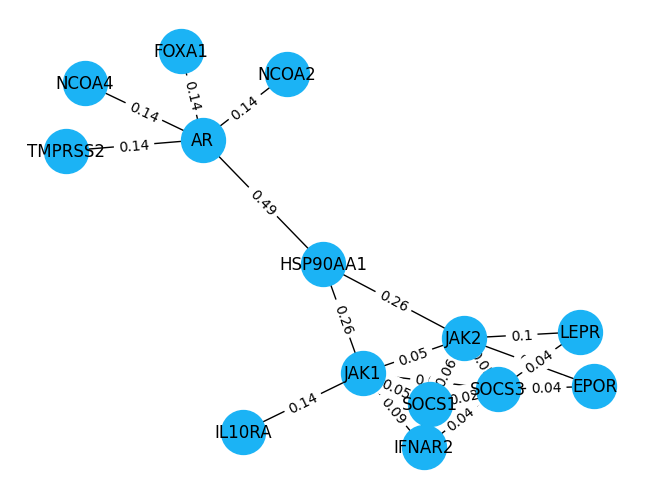

In [11]:
# Calculate the edge betweenness for all edges in the network
edge_betweenness_centrality = nx.edge_betweenness_centrality(STRING_PPI)
edge_betweenness_centrality = {key : round(edge_betweenness_centrality[key], 2) for key in edge_betweenness_centrality}
nx.draw(STRING_PPI, with_labels = True, pos = STRING_PPI_pos, node_size = 1000, node_color = "#1BB3F5")
nx.draw_networkx_edge_labels(STRING_PPI, pos = STRING_PPI_pos, edge_labels = edge_betweenness_centrality)
plt.show()

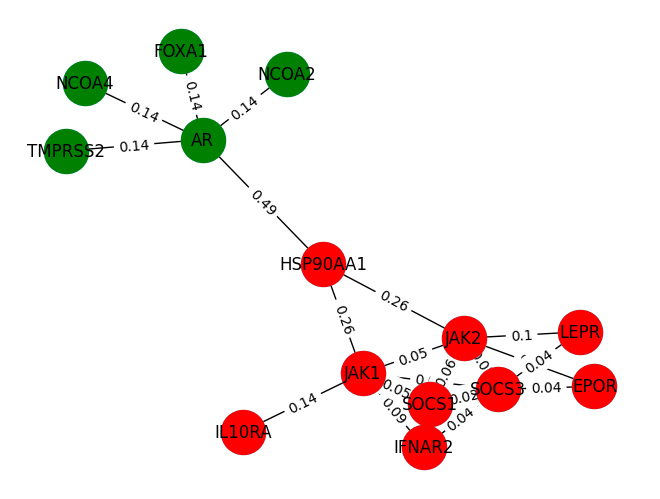

In [12]:
# Use Girvan-Newman algorithm to detect communities in the network
community = girvan_newman(STRING_PPI)
community = tuple(sorted(c) for c in next(community))
nx.draw(STRING_PPI, with_labels = True, pos = STRING_PPI_pos, node_size = 1000, node_color = "#1BB3F5")
nx.draw_networkx_edge_labels(STRING_PPI, pos = STRING_PPI_pos, edge_labels = edge_betweenness_centrality)
nx.draw_networkx_nodes(STRING_PPI, STRING_PPI_pos, nodelist = community[0], node_size = 1000, node_color = "green")
nx.draw_networkx_nodes(STRING_PPI, STRING_PPI_pos, nodelist = community[1], node_size = 1000, node_color = "red")
plt.show()

In the above network, it can be seen that the network was divided into two communities (denoted by the two colours). The edge connecting AR and HSP90AA1 had the highest edge betweenness.

<p style="padding: 10px 10px 10px 10px; border: 2px solid blue;">
<b>Box 2.2: Evaluating quality of the comunities</b><br>
The quality of the communities detected within a network can be evaluated using the following metrics in NetworkX:<br>
<b>Coverage:</b> The coverage of a partition is the ratio of the number of intra-community edges to the total number of edges in the graph.<br>
<b>Performance:</b> The performance of a partition is the number of intra-community edges plus inter-community non-edges divided by the total number of potential edges.
</p>

In [13]:
print("Modularity: ", nx.algorithms.community.modularity(STRING_PPI, community))
print("Coverage: ", nx.algorithms.community.partition_quality(STRING_PPI, community)[0])
print("Preformance: ", nx.algorithms.community.partition_quality(STRING_PPI, community)[0])

Modularity:  0.2891156462585034
Coverage:  0.9523809523809523
Preformance:  0.9523809523809523


### Self-study material:

- <a href = "https://networkx.guide/algorithms/shortest-path/dijkstra/" target = "_blank">Dijkstra’s algorithm</a>
- <a href = "https://towardsdatascience.com/random-walks-with-restart-explained-77c3fe216bca" target = "_blank">Random Walks with Restart Explained</a>
- <a href = "https://doi.org/10.1073/pnas.0400054101" target = "_blank">Defining and identifying communities in networks</a>
- <a href = "https://memgraph.com/blog/community-detection-algorithms-with-python-networkx" target = "_blank">Understanding Community Detection Algorithms with Python NetworkX</a>

